In [1]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
from monai.transforms import (
    Activations,
    Activationsd,
    AddChannel,
    AsDiscrete,
    AsDiscreted,
    AsChannelFirst,
    Compose,
    ConvertToMultiChannelBasedOnBratsClassesd,
    Invertd,
    LoadImaged,
    LabelToMask,
    LoadImage,
    MapTransform,
    NormalizeIntensity,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCrop,
    Resize,
    RandFlip,
    RandRotate,
    Spacing,
    Spacingd,
    ScaleIntensity, 
    SpatialCrop,
    ToTensor,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Resized
)
from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np

#from img2vec_pytorch import Img2Vec
from PIL import Image
from matplotlib import cm
from torch import nn
import torch.nn.functional as F
from natsort import natsorted

#UMAP imports
import umap
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
%matplotlib inline

from utils import ConvertLabelBrats

from monai.networks.nets import AHNet, DenseNet121
#from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
print(monai.__version__) 

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)




0.8.0
MONAI version: 0.8.0
Numpy version: 1.19.5
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
imtrans = Compose(
    [   LoadImage(image_only=True),
         Spacing(
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
            image_only = True,
        ),
        #ScaleIntensity(),
        #NormalizeIntensity(nonzero=True, channel_wise=True),
        AsChannelFirst(),
        ToTensor(),
        #AddChannel(),
        #EnsureType(),
        #Resized,
        #RandFlip(prob=0.5, spatial_axis=0),
        RandRotate(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
        Resize(spatial_size=(112,112,72))
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        #AsChannelFirst(),
        ToTensor(),
        AddChannel(),
        #ConvertLabelBrats(keys=(1,2,4)),
         #EnsureType(),
        #Resized,
        Resize(spatial_size=(112,112,72),mode='nearest')
    ]
)


In [4]:
LIEU = 'sebastian_laptop'

if LIEU=='sebastian_insel':
    root_exp  = '/home/sebastian/experiments/fedem/'
    root_data = '/media/sebastian/data/ASAP/BRATS_2019_ubelix/center_wise/'
    brats_nifti__dir_paths = natsorted(glob(root_data+"**/**/"))

if LIEU=='sebastian_laptop':
    root_exp  = '/Users/sebastianotalora/work/postdoc/federated_learning/fedem/'
    root_data = '/Users/sebastianotalora/work/postdoc/federated_learning/data/'
    brats_nifti__dir_paths = natsorted(glob(root_data+'brats/'"**/**/"))
len(brats_nifti__dir_paths)#Should be 259

259

In [5]:
EXP_TYPE = 'FEDERATED' #FEDERATED
if EXP_TYPE == 'FEDERATED':
    train_ids_centers = []
    val_ids_centers   = []
    test_ids_centers  = []
    for i in range(1,5): #four centers for BraTS
        train_file = root_exp +  '/data/partitions/federated_brats/brats_federated_training_center_'+str(i)+'.txt'
        valid_file = root_exp +  '/data/partitions/federated_brats/brats_federated_validation_center_'+str(i)+'.txt'
        test_file = root_exp +  '/data/partitions/federated_brats/brats_federated_test_center_'+str(i)+'.txt'
        train_ids_centers.append(tuple(open(train_file).read().split('\n')))
        val_ids_centers.append(tuple(open(valid_file).read().split('\n')))
        test_ids_centers.append(tuple(open(test_file).read().split('\n')))    
if EXP_TYPE == 'CENTRALIZED':
    train_ids = tuple(open(root_exp+'data/partitions/brats_centralized_train.txt').read().split('\n'))
    val_ids = tuple(open(root_exp+'data/partitions/brats_centralized_validation.txt').read().split('\n'))
    test_ids = tuple(open(root_exp+'data/partitions/brats_centralized_test.txt').read().split('\n'))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
count_saving = 0
train_volumes_paths, train_labels_paths = [],[]
validation_volumes_paths, validation_labels_paths = [],[]
test_volumes_paths, test_labels_paths = [],[]

train_ids = train_ids_centers[0]
val_ids   = val_ids_centers[0]
test_ids = test_ids_centers[0]

for item in brats_nifti__dir_paths:
    if item.split('/')[-2] in set(train_ids):
        train_volumes_paths.append(item+"stacked.nii.gz")
        train_labels_paths.append(item+"gt.nii.gz")
    if item.split('/')[-2] in set(val_ids):
        validation_volumes_paths.append(item+"stacked.nii.gz")
        validation_labels_paths.append(item+"gt.nii.gz")
    if item.split('/')[-2] in set(test_ids):
        test_volumes_paths.append(item+"stacked.nii.gz")
        test_labels_paths.append(item+"gt.nii.gz")
print(len(train_volumes_paths),len(validation_volumes_paths),len(test_volumes_paths))


14 2 4


In [8]:
train_ds    = ArrayDataset(train_volumes_paths, imtrans, train_labels_paths, segtrans)
validation_ds    = ArrayDataset(validation_volumes_paths, imtrans, validation_labels_paths, segtrans)
test_ds    = ArrayDataset(test_volumes_paths, imtrans, test_labels_paths, segtrans)

In [9]:
len(train_ds + validation_ds)

16

In [10]:
embedding_model = DenseNet121(pretrained=True, spatial_dims = 2, in_channels=4,out_channels = 1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/sebastianotalora/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [11]:
vol_example = train_ds[0][0]
print(vol_example.shape)

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


torch.Size([4, 112, 112, 72])


In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
embedding_model.features.denseblock4.register_forward_hook(get_activation('norm5'))

In [13]:
sample = vol_example
def all_slice_embeddings(sample,embedding_model):
    slice_embeddings = []
    for i in range(sample.shape[-1]):#Loop over all the slices
        cur_slice  = sample[np.newaxis,:,:,:,i]
        cur_output = embedding_model(cur_slice)[0]    
        slice_embeddings.append(np.average(np.average(activation['norm5'],axis=2),axis=2)[0])
    slice_embeddings = torch.tensor(np.array(slice_embeddings))
    return slice_embeddings

In [88]:
for current_center in range(len(train_ids_centers)):
    print(f"=======Computing embeddings for center {current_center} =======")
    train_volumes_paths, train_labels_paths = [],[]
    validation_volumes_paths, validation_labels_paths = [],[]
    test_volumes_paths, test_labels_paths = [],[]

    train_ids = train_ids_centers[current_center]
    val_ids   = val_ids_centers[current_center]
    test_ids = test_ids_centers[current_center]

    for item in brats_nifti__dir_paths:
        if item.split('/')[-2] in set(train_ids):
            train_volumes_paths.append(item+"stacked.nii.gz")
            train_labels_paths.append(item+"gt.nii.gz")
        if item.split('/')[-2] in set(val_ids):
            validation_volumes_paths.append(item+"stacked.nii.gz")
            validation_labels_paths.append(item+"gt.nii.gz")
        if item.split('/')[-2] in set(test_ids):
            test_volumes_paths.append(item+"stacked.nii.gz")
            test_labels_paths.append(item+"gt.nii.gz")
    print(len(train_volumes_paths),len(validation_volumes_paths),len(test_volumes_paths))


    train_ds    = ArrayDataset(train_volumes_paths, imtrans, train_labels_paths, segtrans)
    validation_ds    = ArrayDataset(validation_volumes_paths, imtrans, validation_labels_paths, segtrans)
    test_ds    = ArrayDataset(test_volumes_paths, imtrans, test_labels_paths, segtrans)

    train_embeddings, val_embeddings, test_embeddings = [],[],[]
    for j in range(len(train_ds)):
        print(f"Computing the embeddings of training sample {j} out of {len(train_ds)}")
        train_embeddings.append(np.array(all_slice_embeddings(train_ds[j][0],embedding_model)))
    fname = root_exp + '/data/partitions/embeddings/training_embeddings_center_' + str(current_center)+'.npy'
    np.save(fname , np.array(train_embeddings))
    
    for j in range(len(validation_ds)):
        print(f"Computing the embeddings of validation sample {j} out of {len(validation_ds)}")
        val_embeddings.append(np.array(all_slice_embeddings(validation_ds[j][0],embedding_model)))
    fname = root_exp + '/data/partitions/embeddings/validation_embeddings_center_' + str(current_center)+'.npy'    
    np.save(fname , np.array(val_embeddings))
    
    for j in range(len(test_ds)):
        print(f"Computing the embeddings of test sample {j} out of {len(test_ds)}")
        test_embeddings.append(np.array(all_slice_embeddings(test_ds[j][0],embedding_model)))
    fname = root_exp + '/data/partitions/embeddings/test_embeddings_center_' + str(current_center)+'.npy'    
    np.save(fname , np.array(test_embeddings))
    
    

=======Computing embeddings for center 0 =======
14 2 4
Computing the embeddings of training sample 0 out of 14
Computing the embeddings of training sample 1 out of 14
Computing the embeddings of training sample 2 out of 14
Computing the embeddings of training sample 3 out of 14
Computing the embeddings of training sample 4 out of 14
Computing the embeddings of training sample 5 out of 14
Computing the embeddings of training sample 6 out of 14
Computing the embeddings of training sample 7 out of 14
Computing the embeddings of training sample 8 out of 14
Computing the embeddings of training sample 9 out of 14
Computing the embeddings of training sample 10 out of 14
Computing the embeddings of training sample 11 out of 14
Computing the embeddings of training sample 12 out of 14
Computing the embeddings of training sample 13 out of 14
Computing the embeddings of validation sample 0 out of 2
Computing the embeddings of validation sample 1 out of 2
Computing the embeddings of test sample 0 

Computing the embeddings of test sample 20 out of 25
Computing the embeddings of test sample 21 out of 25
Computing the embeddings of test sample 22 out of 25
Computing the embeddings of test sample 23 out of 25
Computing the embeddings of test sample 24 out of 25
=======Computing embeddings for center 2 =======
71 11 20
Computing the embeddings of training sample 0 out of 71
Computing the embeddings of training sample 1 out of 71
Computing the embeddings of training sample 2 out of 71
Computing the embeddings of training sample 3 out of 71
Computing the embeddings of training sample 4 out of 71
Computing the embeddings of training sample 5 out of 71
Computing the embeddings of training sample 6 out of 71
Computing the embeddings of training sample 7 out of 71
Computing the embeddings of training sample 8 out of 71
Computing the embeddings of training sample 9 out of 71
Computing the embeddings of training sample 10 out of 71
Computing the embeddings of training sample 11 out of 71
Com

In [60]:
center_data =  np.array(train_embeddings)
center_data.shape

/tmp/ipykernel_298285/273549558.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  center_data =  np.array(train_embeddings)
/tmp/ipykernel_298285/273549558.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  center_data =  np.array(train_embeddings)


(14,)

In [58]:
reducer = umap.UMAP()

In [72]:
scaled_sample_data = StandardScaler().fit_transform(train_embeddings[0])

In [79]:
embedding = reducer.fit_transform(scaled_sample_data)
embedding.shape


(72, 2)

Text(0.5, 1.0, 'UMAP projection of One Volume in center BraTS19_2013_10_1')

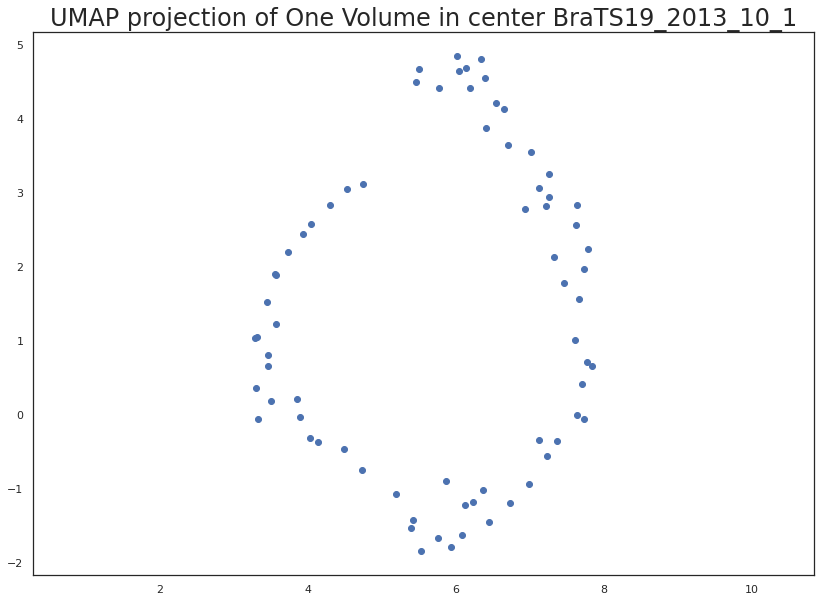

In [80]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of One Volume in center BraTS19_2013_10_1', fontsize=24)
